# Social Media Analysis

With this notebook, you can analyse tweets that were posted in the same area and on the same day as the Napa earthquake in 2014 (see https://en.wikipedia.org/wiki/2014_South_Napa_earthquake for details).  

### Exercise

Create a new markdown cell to answer the following questions (5P):

* How many tweets are in the dataset?
* What words are the most frequent words in the wordcloud (related to the size of the words)?
* Perform  topic modelling with and without preprocessing. What can you observe?
* Which topics can you identify in the datasets? Can you label some of the topics?
* What is the min and max date of the dataset?
* How does the time-series of the disaster-related topic and the overall dataset differ?
* How does the heatmap of the disaster-related topic and the overall dataset differ?
* How do the wordclouds of the sentiments differ?
* How do the sentiments of the time-series for various topics differ?


## Load dataset and libraries

In [2]:
%matplotlib inline
%pip install nltk gensim folium wordcloud pyLDAvis

You should consider upgrading via the '/Users/izzy/.pyenv/versions/3.8.15/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gensim
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium
import pyLDAvis.gensim_models as gensimvis
import statistics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
#df = pd.read_excel('napa_tweets_with_pga.xlsx')
#df = pd.read_csv('napa_tweets_with_pga.csv', sep=';', error_bad_lines=False, index_col=False, warn_bad_lines=False)

df = pd.read_csv('./napa_tweets.csv', sep=',', index_col=False)
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)
  

,id,time,tweet_text,latitude,longitude
0,0,24.08.2014 23:07,SMITE vs LOL ??,37.600700,-122.014820
1,1,24.08.2014 23:12,Random people complimenting you is so nice,38.417359,-122.709612
2,2,24.08.2014 23:37,Calum is being an annoying,37.353794,-121.863898
3,3,24.08.2014 23:38,Plan B,37.957866,-122.032392
4,4,24.08.2014 23:42,Laaawwwwllllll,38.338400,-122.685784


## Natural language processing

Create a wordcloud and find out the most prominent words in the corpus.

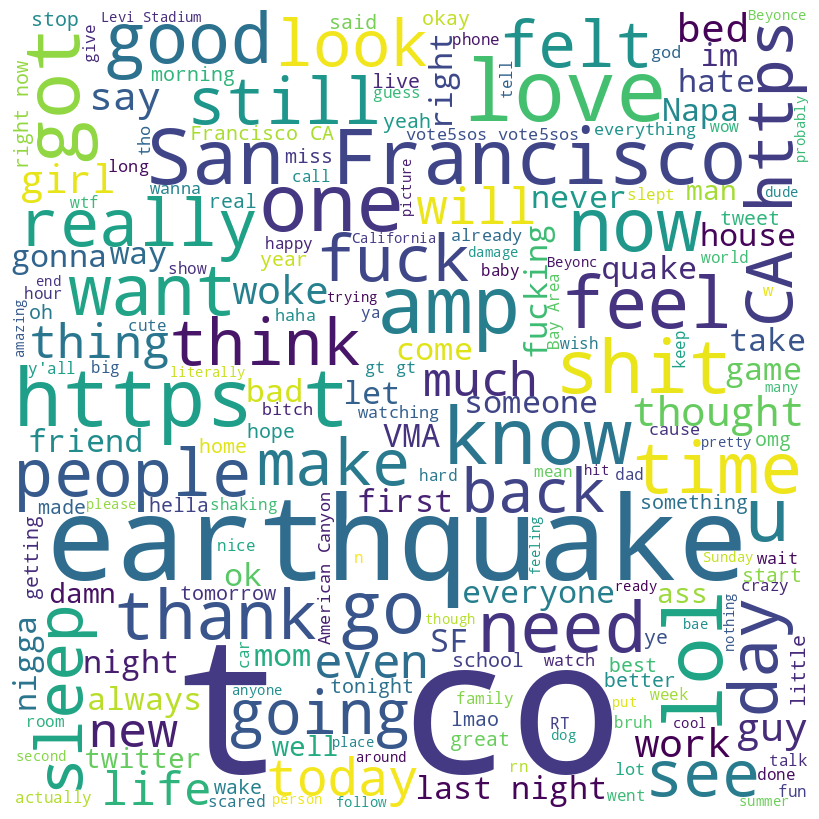

In [5]:
tweet_text = "".join(df.tweet_text)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=set(STOPWORDS),
                min_font_size = 10).generate(tweet_text)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Download nltk Ressources.

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/izzy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/izzy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Transform tweets text into usable format

1. Lower case tweets text
2. Remove URL
3. Tokenize words

In [13]:
import re

def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

processed_text = tweet_text.lower()
processed_text = remove_urls(processed_text)
tokenized_text = nltk.word_tokenize(processed_text)

print(tokenized_text[:15])


['smite', 'vs', 'lol', '?', '?', 'random', 'people', 'complimenting', 'you', 'is', 'so', 'nicecalum', 'is', 'being', 'an']


### Text preprocessing

Test multiple preprocessing procedures and observe their impact on the analysis results

1. Remove special characters
2. Remove short words
3. Remove all user names
4. Remove unique words that appear only once in the dataset
5. Remove stop words (nltk.corpus)
6. Apply stemming
7. Remove empty strings

In [21]:
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def remove_special_chars(tokens):
    pattern = re.compile('[^A-Za-z0-9]+')
    return [token for token in tokens if not pattern.search(token)] 


def remove_short_words(tokens, min_length=3):
    return [token for token in tokens if len(token) >= min_length]


def remove_usernames(tokens):
    return [token for token in tokens if not token.startswith('@')]

def remove_unique_words(tokens):
    counts = Counter(tokens)
    return [token for token in tokens if counts[token] > 1]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token not in stop_words]

def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def remove_empty_strings(tokens):
    return [token for token in tokens if token]

removed_specialc = remove_special_chars(tokenized_text)
removed_shortw = remove_short_words(tokenized_text)
removed_usern = remove_usernames(tokenized_text)
removed_uniquew = remove_unique_words(tokenized_text)
removed_stopw = remove_stop_words(tokenized_text)
stemmed = apply_stemming(tokenized_text)

removed_specialc[:10]









['smite',
 'vs',
 'lol',
 'random',
 'people',
 'complimenting',
 'you',
 'is',
 'so',
 'nicecalum']

Create corpus and dictionary for LDA

In [28]:
documents = [removed_specialc, removed_shortw, removed_usern, removed_uniquew, removed_stopw, stemmed]

dict = gensim.corpora.Dictionary(documents)
corpus = [dict.doc2bow(text) for text in documents]

Train Model and identify best parameters

In [29]:
num_topics = 5
alpha = 0.01
eta = 0.01
passes = 5
lda = gensim.models.LdaMulticore(corpus, id2word=dict, num_topics= num_topics, alpha = alpha, eta= eta, passes = passes)

Show top words of topics

In [30]:
top_words = 5

#show top words of topics
for t in range(lda.num_topics):
    print('topic {}: '.format(t+1) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

#show top words of topics with probabilities  
#for t in range(lda.num_topics):
#   print('topic {}: '.format(t+1) + ', '.join([v[0] + " (" + str(v[1]) + ")" for v in lda.show_topic(t, top_words)]))


topic 1: ?, @, i, #, .
topic 2: ?, @, #, ., !
topic 3: ?, @, i, ., #
topic 4: the, i, you, and, to
topic 5: ?, #, i, @, !


### Visualise topics and check relation between them
If the window is not big enough, you can enlarge it with Cell -> Current Outputs -> Toggle Scrolling 

In [ ]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=False)
print(vis.topic_order)
pyLDAvis.display(vis)

Identify disaster-related topic (manually) and classify tweets accordingly -> check lda.get_document_topics(corpus)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Check classified tweets. Print the first tweets of a topic

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Check time-series

Show time series of the whole dataset and then check the time series of two topics.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Check geospatial distribution

Display tweets on a ma and apply heatmap on the tweets. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

More information

* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Combining machine-learning topic models and spatiotemporal analysis of social media data for disaster footprint and damage assessment](https://www.tandfonline.com/doi/full/10.1080/15230406.2017.1356242)
* [Gensim](https://radimrehurek.com/gensim/)

# Classify Tweet sentiments

Finally, let us use a state-of-the-art artificial intelligence sentiment classification method, called RoBERTa. RoBERTA stands for Robustly Optimized BERT Pretraining Approach and can be used for different natural language processing tasks.

Orignal paper: https://arxiv.org/abs/1907.11692

Code source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment


## Load the model
Run the code below

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

### Preprocessing the data

1. Remove user information
2. Remove URL

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Test the model

Preprocess the text and apply autotokenizer by writing the function "get_sentiment"

In [ ]:
text = "Good night 😊"
text = preprocess(text)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
get_sentiment(text)

#### Try your own examples


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Classify the sentiment for a random sample of size 1000

1. Preprocess the data and apply tokenizer (measure time)

In [ ]:
df_sent = df.sample(1000)
df_sent['sentiment'] = 'no_sentiment'

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Number of positive tweets: ', (len(df_sent[df_sent.sentiment == 'positive'])))
print('Number of negative tweets: ', (len(df_sent[df_sent.sentiment == 'negative'])))
print('It took %d seconds to get the sentiment for %d tweets'%((end-start), len(df_sent)))

## Build and compare wordclouds according to the diffferent sentiments 

### Postive

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Negative

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Neutral

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Compare sentiment timelines for different topics

Napa earthquake took place at 03:20:44 Pacific Daylight Time which is 10:20:44 in GMT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()